In [27]:
import torch
torch.set_grad_enabled(False) # REQUIRED

## 1. Generating the data

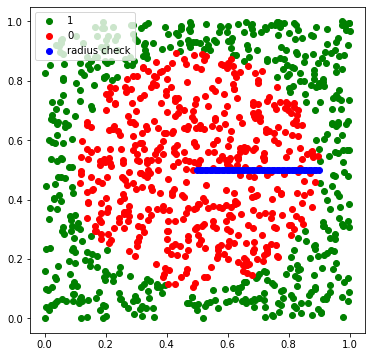

In [28]:
from utils import generate_dataset, show_dataset

X_train, y_train, X_test, y_test = generate_dataset(1000)
show_dataset(X_train, y_train[:,1])

### Testing linear regression

Text(0.5, 1.0, 'Error on b')

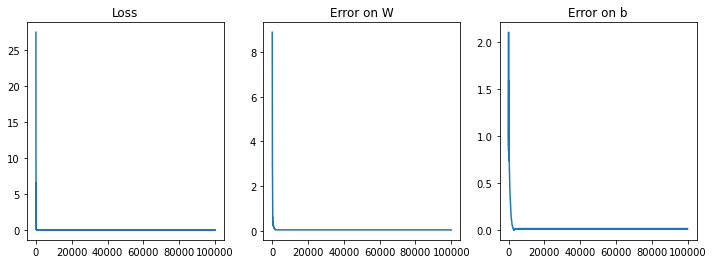

In [29]:
from module import Linear, ReLU, Tanh, LossMSE
import matplotlib.pyplot as plt
from torch import empty




n_samples = 1000
input_dim = 20
output_dim = 2

x0 = empty((n_samples, input_dim)).uniform_()


y = empty((n_samples, output_dim)).uniform_()


W = empty((output_dim, input_dim)).normal_(0, 1)
b = empty(output_dim).normal_(0, 1)
y = empty((n_samples, output_dim)).zero_() 


for i in range(n_samples):
    x = x0[i]
    y[i] = W.mv(x) + b
    
y += 0.05*empty(y.shape).normal_(0, 1)
    
ll = Linear(input_dim, output_dim)
LS = LossMSE()


losses, d_w, d_b = [], [], []


nb_epochs = 10000
mini_batch_size = 100
lr = 1e-1/n_samples*mini_batch_size



for epoch in range(nb_epochs):
    ll.zero_grad()
    for i in range(0, x0.size(0), mini_batch_size):
        input_ = x0.narrow(0, i, mini_batch_size)
        target = y.narrow(0, i, mini_batch_size)
        x2 = ll.forward(input_)
        
        loss = LS.forward(x2, target)

        grad_output = LS.backward()
        grad_input = ll.backward(grad_output)
        

        ll.W -= lr*ll.grad_W
        ll.b -= lr*ll.grad_b
        losses.append(loss.item())
        d_w.append((W-ll.W).norm())
        d_b.append((b-ll.b.squeeze()).norm())
    
f, ax = plt.subplots(1, 3, figsize = (12, 4))

ax[0].plot(losses)
ax[0].set_title('Loss')
ax[1].plot(d_w)
ax[1].set_title('Error on W')
ax[2].plot(d_b)
ax[2].set_title('Error on b')

In [30]:
W - ll.W

tensor([[ 6.5207e-04, -3.8301e-03,  1.5063e-03, -5.9723e-03,  6.5741e-03,
          6.4346e-03,  5.6939e-03, -1.1197e-02, -1.1206e-03, -4.2975e-03,
          1.1581e-02, -1.0059e-02,  3.5961e-03, -4.8342e-03, -1.0367e-02,
          5.8814e-03, -1.0276e-04,  7.5372e-03, -2.8510e-03, -1.2147e-02],
        [ 1.2748e-02, -1.0517e-02,  7.5188e-03,  4.0787e-04,  4.6859e-03,
          6.9495e-03,  1.9776e-03, -1.9653e-03, -2.3386e-03, -4.8492e-03,
         -1.1133e-02,  5.7220e-05,  6.0337e-03,  2.1323e-03,  2.0751e-03,
          3.8109e-03, -6.4768e-03,  5.2845e-03,  3.1862e-03,  7.4050e-03]])

In [31]:
b - ll.b

tensor([ 0.0083, -0.0108])

In [32]:
d_w[-1], d_b[-1]

(tensor(0.0412), tensor(0.0137))

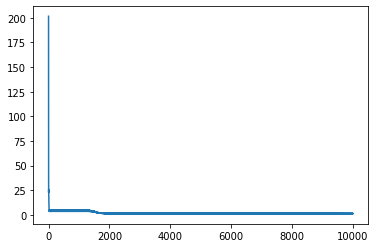

In [33]:
LS = LossMSE()

hidden_dim = 5
L1 = Linear(input_dim, hidden_dim)
R = ReLU()
L2 = Linear(hidden_dim, output_dim)

losses, d_w, d_b = [], [], []


nb_epochs = 1000
mini_batch_size = 100
lr = 1e-1/n_samples*mini_batch_size



for epoch in range(nb_epochs):
    L1.zero_grad()
    L2.zero_grad()
    for i in range(0, x0.size(0), mini_batch_size):
        input_ = x0.narrow(0, i, mini_batch_size)
        target = y.narrow(0, i, mini_batch_size)
        
        # forward pass
        x1 = L1.forward(input_)
        s1 = R.forward(x1)
        x2 = L2.forward(s1)
        loss = LS.forward(x2, target)
        # backward pass
        grad_x2 = LS.backward()
        grad_s1 = L2.backward(grad_x2)
        grad_x1 = R.backward(grad_s1)
        grad_input = L1.backward(grad_x1)
        

        L1.W -= lr*L1.grad_W
        L1.b -= lr*L1.grad_b
        
        L2.W -= lr*L2.grad_W
        L2.b -= lr*L2.grad_b
        
        losses.append(loss.item())
    

plt.plot(losses)


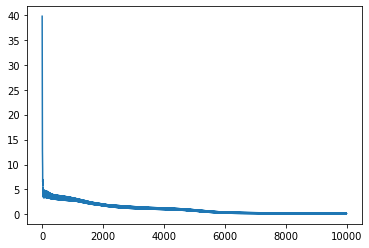

In [34]:
from module import Sequential 


hidden_1, hidden_2 = 6, 3
model = Sequential(Linear(input_dim, hidden_1), 
                   Tanh(),
                   Linear(hidden_1, hidden_2), 
                   Tanh(),
                   Linear(hidden_2, output_dim))


losses, d_w, d_b = [], [], []


nb_epochs = 1000
mini_batch_size = 100
lr = 1e-2/n_samples*mini_batch_size



for epoch in range(nb_epochs):
    model.zero_grad()
    
    for i in range(0, x0.size(0), mini_batch_size):
        input_ = x0.narrow(0, i, mini_batch_size)
        target = y.narrow(0, i, mini_batch_size)
        
        # forward pass
        out = model.forward(input_)
        loss = LS.forward(out, target)
        # backward pass
        grad_output = LS.backward()
        grad_input = model.backward(grad_output)
        
        for layer in model.layers:
            if layer.trainable:
                layer.W -= lr*layer.grad_W
                layer.b -= lr*layer.grad_b
        
        losses.append(loss.item())
    

plt.plot(losses)


### Testing on MNIST

In [35]:
from dlc_practical_prologue import load_data

train_input, train_target, test_input, test_target = load_data(one_hot_labels = True, normalize = True, flatten = True)

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


In [36]:
train_input.shape, train_target.shape

(torch.Size([1000, 784]), torch.Size([1000, 10]))

Epoch 1: loss = 60.547, accuracy = 11.3% (train)/12.7% (test))
Epoch 51: loss = 2.502, accuracy = 35.4% (train)/13.9% (test))
Epoch 101: loss = 1.609, accuracy = 42.0% (train)/18.0% (test))
Epoch 151: loss = 1.343, accuracy = 46.2% (train)/19.0% (test))
Epoch 201: loss = 1.200, accuracy = 48.8% (train)/20.1% (test))
Epoch 251: loss = 1.109, accuracy = 50.9% (train)/20.6% (test))
Epoch 301: loss = 1.049, accuracy = 52.4% (train)/20.9% (test))
Epoch 351: loss = 1.007, accuracy = 53.4% (train)/21.3% (test))
Epoch 401: loss = 0.973, accuracy = 53.7% (train)/22.3% (test))
Epoch 451: loss = 0.944, accuracy = 54.7% (train)/22.8% (test))
Epoch 501: loss = 0.920, accuracy = 56.1% (train)/23.7% (test))
Epoch 551: loss = 0.902, accuracy = 57.2% (train)/23.4% (test))
Epoch 601: loss = 0.887, accuracy = 57.7% (train)/24.2% (test))
Epoch 651: loss = 0.874, accuracy = 58.2% (train)/24.8% (test))
Epoch 701: loss = 0.861, accuracy = 58.9% (train)/25.1% (test))
Epoch 751: loss = 0.851, accuracy = 59.1% 

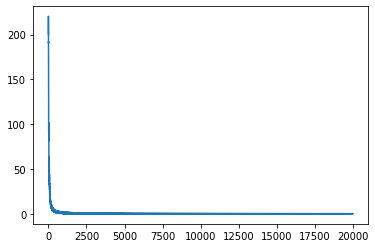

In [37]:
input_dim, h1, h2, h3, output_dim = 28**2, 100, 50, 20, 10

model = Sequential(Linear(input_dim, h1), 
                   Tanh(),
                   Linear(h1, h2), 
                   Tanh(),
                   Linear(h2, h3),
                   Tanh(),
                   Linear(h3, output_dim))


losses, d_w, d_b = [], [], []


nb_epochs = 1000
mini_batch_size = 50
lr = 1e-2/n_samples*mini_batch_size



for epoch in range(nb_epochs):
    
    model.zero_grad()
    
    for i in range(0, train_input.size(0), mini_batch_size):
        input_ = train_input.narrow(0, i, mini_batch_size)
        target = train_target.narrow(0, i, mini_batch_size)
        
        # forward pass
        out = model.forward(input_)
        loss = LS.forward(out, target)
        # backward pass
        grad_output = LS.backward()
        grad_input = model.backward(grad_output)
        
        for layer in model.layers:
            if layer.trainable:
                layer.W -= lr*layer.grad_W
                layer.b -= lr*layer.grad_b
        
        losses.append(loss.item())
        
    if epoch %50 == 1:
        prediction_train = model.forward(train_input).argmax(axis = 1)
        target_train = train_target.argmax(axis = 1)
        accuracy_train = (prediction_train == target_train).sum()/len(target_train)
        prediction_test = model.forward(test_input).argmax(axis = 1)
        target_test = test_target.argmax(axis = 1)
        accuracy_test = (prediction_test == target_test).sum()/len(target_test)
        print('Epoch {:d}: loss = {:.3f}, accuracy = {:.1f}% (train)/{:.1f}% (test))'.format(epoch, loss.item(),
                                                                                             accuracy_train*100, 
                                                                                             accuracy_test*100))
    
plt.plot(losses)